<a href="https://colab.research.google.com/github/Eclipse-peach/pca-performance_mlp/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA Example


--- PCA Explained Variance Ratio ---
Principal Component 1 explains: 80.94% of variance
Principal Component 2 explains: 15.21% of variance
Total variance explained by 2 components: 96.16%
----------------------------------------


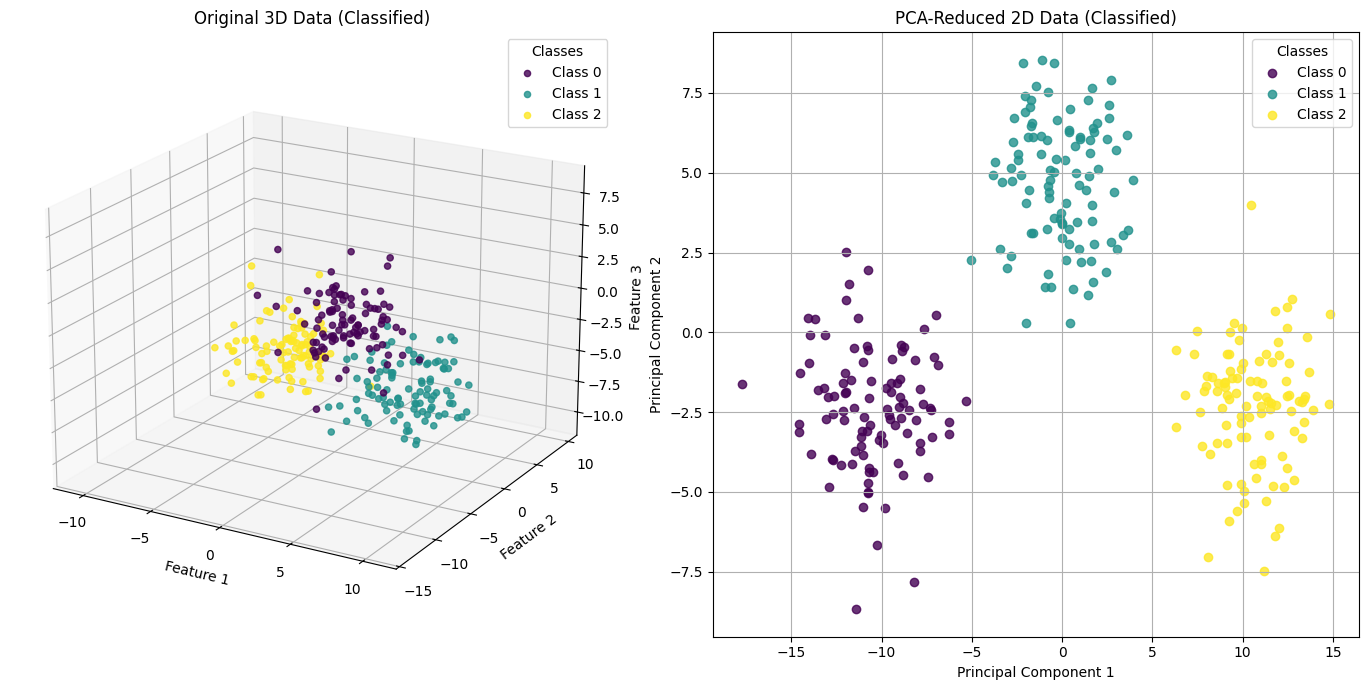

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

# Generate a 3D dataset with clear classifications (clusters)
n_samples = 300
n_features = 3
n_centers = 3 # Number of distinct classes/clusters
random_state = 10

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers,
                  cluster_std=2.0, random_state=random_state)

X_Copy = X


# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)


print("\n--- PCA Explained Variance Ratio ---")
print(f"Principal Component 1 explains: {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"Principal Component 2 explains: {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print("-" * 40)


# Get unique class labels for consistent plotting and legend
unique_classes = np.unique(y)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes))) # Use a colormap for distinct colors

# Plotting the original 3D data with colors based on class and a legend
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(121, projection='3d')
for i, class_label in enumerate(unique_classes):
    ax1.scatter(X[y == class_label, 0], X[y == class_label, 1], X[y == class_label, 2],
                color=colors[i], marker='o', alpha=0.8, label=f'Class {class_label}')
ax1.set_title('Original 3D Data (Classified)')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')
ax1.view_init(elev=20, azim=-60)
ax1.legend(title="Classes") # Add legend for classes

# Plotting the PCA-reduced 2D data with colors based on class and a legend
ax2 = fig.add_subplot(122)
for i, class_label in enumerate(unique_classes):
    ax2.scatter(X_reduced[y == class_label, 0], X_reduced[y == class_label, 1],
                color=colors[i], marker='o', alpha=0.8, label=f'Class {class_label}')
ax2.set_title('PCA-Reduced 2D Data (Classified)')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.grid(True)
ax2.legend(title="Classes") # Add legend for classes

plt.tight_layout()
plt.show()

--- Iris Dataset: Separated by Species ---


sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
5.10,3.50,1.40,0.20,setosa
4.90,3.00,1.40,0.20,setosa
4.70,3.20,1.30,0.20,setosa
4.60,3.10,1.50,0.20,setosa
5.00,3.60,1.40,0.20,setosa
5.40,3.90,1.70,0.40,setosa
4.60,3.40,1.40,0.30,setosa
5.00,3.40,1.50,0.20,setosa
4.40,2.90,1.40,0.20,setosa
4.90,3.10,1.50,0.10,setosa


sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
7.00,3.20,4.70,1.40,versicolor
6.40,3.20,4.50,1.50,versicolor
6.90,3.10,4.90,1.50,versicolor
5.50,2.30,4.00,1.30,versicolor
6.50,2.80,4.60,1.50,versicolor
5.70,2.80,4.50,1.30,versicolor
6.30,3.30,4.70,1.60,versicolor
4.90,2.40,3.30,1.00,versicolor
6.60,2.90,4.60,1.30,versicolor
5.20,2.70,3.90,1.40,versicolor


sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
6.30,3.30,6.00,2.50,virginica
5.80,2.70,5.10,1.90,virginica
7.10,3.00,5.90,2.10,virginica
6.30,2.90,5.60,1.80,virginica
6.50,3.00,5.80,2.20,virginica
7.60,3.00,6.60,2.10,virginica
4.90,2.50,4.50,1.70,virginica
7.30,2.90,6.30,1.80,virginica
6.70,2.50,5.80,1.80,virginica
7.20,3.60,6.10,2.50,virginica




--------------------------------------------------

--- PCA Explained Variance Ratio ---
Principal Component 1 explains: 92.46% of variance
Principal Component 2 explains: 5.31% of variance
Total variance explained by 2 components: 97.77%
----------------------------------------


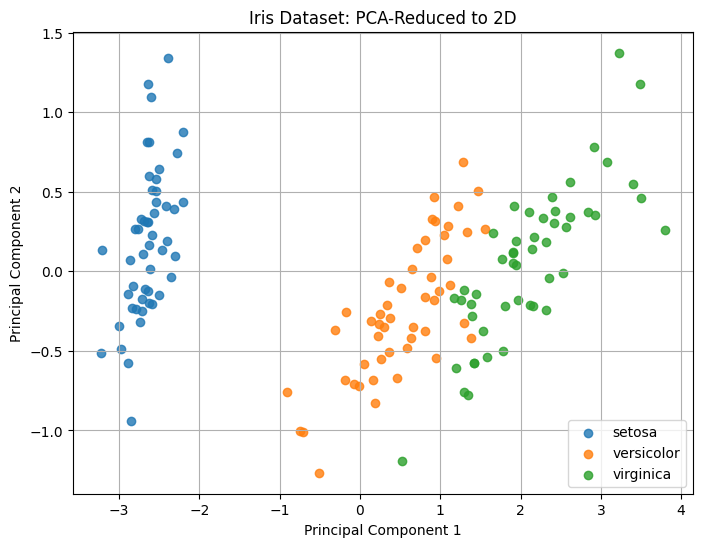

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Load the Iris dataset
iris = load_iris()
X = iris.data  # Features (sepal length, sepal width, petal length, petal width)
y = iris.target # Target species (0: setosa, 1: versicolor, 2: virginica)
feature_names = iris.feature_names
target_names = iris.target_names

# 2. Create a Pandas DataFrame
df_iris = pd.DataFrame(X, columns=feature_names)
df_iris['species'] = y
# Map numerical targets to actual species names for clarity
df_iris['species'] = df_iris['species'].map({i: name for i, name in enumerate(target_names)})

# --- Awesome Tables for Each Species ---

# Define a base styling function to keep the code clean
def style_species_table(df, species_name):
    """Applies consistent styling to each species DataFrame."""
    return (
        df.style
        .set_caption(f"Iris {species_name.capitalize()} Data") # Dynamic caption
        .set_table_styles([
            {'selector': 'caption', 'props': [('font-size', '1.2em'), ('font-weight', 'bold'), ('color', '#333333')]},
            {'selector': 'th', 'props': [('background-color', '#e0f2f7'), ('color', 'black'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
            {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#000000')]}
        ])
        .format({ # Format float columns to 2 decimal places
            'sepal length (cm)': "{:.2f}",
            'sepal width (cm)': "{:.2f}",
            'petal length (cm)': "{:.2f}",
            'petal width (cm)': "{:.2f}"
        })
        .hide(axis="index") # Hide the default pandas index
    )

print("--- Iris Dataset: Separated by Species ---")

# Separate and display tables for each species
for i, species_name in enumerate(target_names):
    df_species = df_iris[df_iris['species'] == species_name].copy() # Filter and make a copy
    styled_table = style_species_table(df_species, species_name)
    display(styled_table)
    print("\n") # Add a newline for visual separation between tables

print("-" * 50)


# --- Your PCA and Plotting Code (unchanged) ---

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("\n--- PCA Explained Variance Ratio ---")
print(f"Principal Component 1 explains: {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"Principal Component 2 explains: {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print("-" * 40)

# Plot the PCA-reduced 2D data
plt.figure(figsize=(8, 6))

# Plot each species separately to create a legend
for i, target_name in enumerate(target_names):
    plt.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1],
                label=target_name, alpha=0.8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Iris Dataset: PCA-Reduced to 2D')
plt.legend()
plt.grid(True)
plt.show()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)
0.9647999


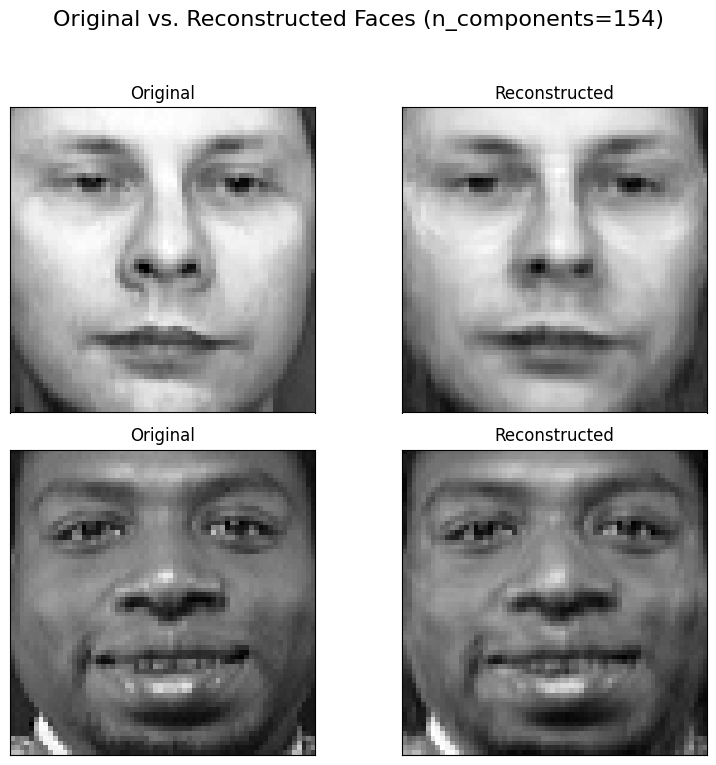

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
import numpy as np

# Load the Olivetti Faces dataset
data = fetch_olivetti_faces(shuffle=True, random_state=42)
faces_image = data.images
faces_flat = data.data
faces_target = data.target

n_samples, height, width = faces_image.shape
n_features = height * width
n_classes = len(np.unique(faces_target))

print(faces_image.shape)

pca_face = PCA()
pca_face.fit(faces_flat)
cumsum = np.cumsum(pca_face.explained_variance_ratio_)
print(cumsum[153])
# Choose the number of principal components
n_components = 154

# Initialize and fit PCA
pca2 = PCA(n_components=n_components)
faces_reduced = pca2.fit_transform(faces_flat)

# Reconstruct the images from the reduced data
faces_reconstructed = pca2.inverse_transform(faces_reduced)
faces_reconstructed = faces_reconstructed.reshape(n_samples, height, width)

# Plot the first 4 original and reconstructed images
n_rows = 2
n_cols = 2
plt.figure(figsize=(8, 8))
plt.suptitle(f"Original vs. Reconstructed Faces (n_components={n_components})", fontsize=16)

for i in range(n_cols):
    # Original image
    plt.subplot(n_rows, n_cols, 2 * i + 1)
    plt.imshow(faces_image[i+2], cmap='gray')
    plt.title("Original")
    plt.xticks([])
    plt.yticks([])

    # Reconstructed image
    plt.subplot(n_rows, n_cols, 2 * i + 2)
    plt.imshow(faces_reconstructed[i+2], cmap='gray')
    plt.title("Reconstructed")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Train MNIST DataSet With PCA

In [ ]:
import tensorflow as tf
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import numpy as np

# 1. Load and Preprocess MNIST Data
print("Loading MNIST data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype('int')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pca_plot = PCA()
pca_plot.fit(X_train)
cumsum = np.cumsum(pca_plot.explained_variance_ratio_)
print(cumsum[153])
# Prepare original (unscaled) data for MLP input (if you still want to run the original MLP)
# Note: For the 'original' MLP, it's still generally best practice to scale it.
# If you run the 'original' MLP with unscaled X_train, its performance might drop.
# I'll keep it scaled for the 'original' MLP for fair comparison, but you can change it if you wish.
scaler_for_original_mlp = StandardScaler()
X_train_flattened_original_mlp = scaler_for_original_mlp.fit_transform(X_train).astype('float32')
X_test_flattened_original_mlp = scaler_for_original_mlp.transform(X_test).astype('float32')

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)


# --- New PCA and Scaling Sequence ---

# First, apply PCA to the UNSCALED training data
print("\nPerforming PCA on UNSCALED training data...")
pca_unscaled = PCA(n_components=0.95) # Target 95% variance on unscaled data

X_train_pca_unscaled = pca_unscaled.fit_transform(X_train)
X_test_pca_unscaled = pca_unscaled.transform(X_test)

# Get the number of components chosen by PCA on unscaled data
n_components_pca_unscaled = pca_unscaled.n_components_
print(f"PCA on unscaled data chose {n_components_pca_unscaled} components to explain 95% variance.")

# Second, scale the PCA results
print("Scaling the PCA-transformed data...")
scaler_pca_results = StandardScaler()
X_train_pca_scaled = scaler_pca_results.fit_transform(X_train_pca_unscaled).astype('float32')
X_test_pca_scaled = scaler_pca_results.transform(X_test_pca_unscaled).astype('float32')


# 2. Define the Multi-Layer Perceptron (MLP) Model
def create_mlp_model(input_dim):
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

# 3. Train the MLP Model on Original (Flattened, scaled) Data and Measure Time
# (Keeping this part with scaled data for fairness to the 'original' benchmark)
print("\nTraining MLP model on original (flattened, scaled) data...")
model_mlp_original = create_mlp_model(X_train_flattened_original_mlp.shape[1])
model_mlp_original.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time_mlp_original = time.time()
model_mlp_original.fit(X_train_flattened_original_mlp, y_train_categorical, epochs=10, batch_size=32, verbose=0)
end_time_mlp_original = time.time()
training_time_mlp_original = end_time_mlp_original - start_time_mlp_original

_, accuracy_mlp_original = model_mlp_original.evaluate(X_test_flattened_original_mlp, y_test_categorical, verbose=0)
print(f"Original (flattened, scaled) data - Training Time: {training_time_mlp_original:.2f} seconds, Test Accuracy: {accuracy_mlp_original:.4f}")


# 5. Train the SAME MLP Model on PCA-Reduced and THEN Scaled Data and Measure Time
print("\nTraining the SAME MLP model on PCA-reduced (unscaled), then scaled data...")
model_mlp_pca_then_scaled = create_mlp_model(n_components_pca_unscaled) # Input dim is the result of PCA on unscaled data
model_mlp_pca_then_scaled.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time_mlp_pca_then_scaled = time.time()
model_mlp_pca_then_scaled.fit(X_train_pca_scaled, y_train_categorical, epochs=10, batch_size=32, verbose=0)
end_time_mlp_pca_then_scaled = time.time()
training_time_mlp_pca_then_scaled = end_time_mlp_pca_then_scaled - start_time_mlp_pca_then_scaled

_, accuracy_mlp_pca_then_scaled = model_mlp_pca_then_scaled.evaluate(X_test_pca_scaled, y_test_categorical, verbose=0)
print(f"PCA-reduced (unscaled), then scaled data - Training Time: {training_time_mlp_pca_then_scaled:.2f} seconds, Test Accuracy: {accuracy_mlp_pca_then_scaled:.4f}")

print("\nComparison of Training Times (MLP):")
print(f"Original (flattened, scaled) Data Training Time: {training_time_mlp_original:.2f} seconds")
print(f"PCA-then-Scaled Data Training Time: {training_time_mlp_pca_then_scaled:.2f} seconds")

Loading MNIST data...
0.9504127888294238

Performing PCA on UNSCALED training data...
PCA on unscaled data chose 154 components to explain 95% variance.
Scaling the PCA-transformed data...

Training MLP model on original (flattened, scaled) data...
Original (flattened, scaled) data - Training Time: 69.29 seconds, Test Accuracy: 0.9720

Training the SAME MLP model on PCA-reduced (unscaled), then scaled data...
PCA-reduced (unscaled), then scaled data - Training Time: 48.54 seconds, Test Accuracy: 0.9638

Comparison of Training Times (MLP):
Original (flattened, scaled) Data Training Time: 69.29 seconds
PCA-then-Scaled Data Training Time: 48.54 seconds


154


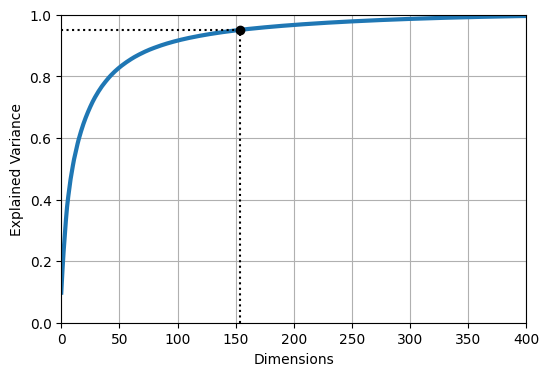

In [ ]:
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154
print(d)

# 아래 그림 생성 코드
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.show()


--- Testing Individual Images ---


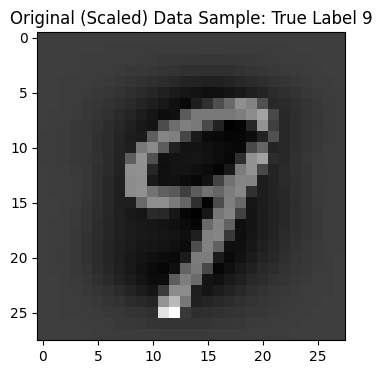

Original MLP Model Prediction: 9


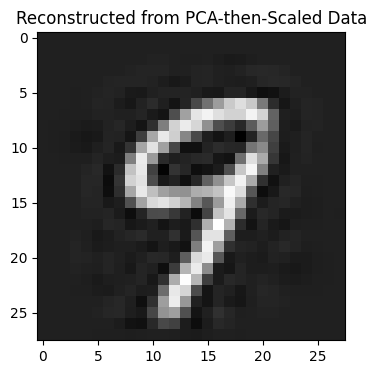

PCA-then-Scaled MLP Model Prediction: 9


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PIL_Image

# 5. Function to get raw (unscaled) user handwritten image pixels
def get_raw_user_img_pixels(img_path, target_size=(28, 28)):
    try:
        img = PIL_Image.open(img_path).convert('L') # Grayscale
        img = img.resize(target_size)
        img_arr = np.array(img).astype('float32')
        img_arr = 255 - img_arr # Invert colors (MNIST is white on black)
        return img_arr.reshape(1, -1) # Flatten to (1, 784)
    except FileNotFoundError:
        print(f"Error: Image not found at {img_path}")
        return None

# 6. Function to preprocess for the "PCA on Unscaled, then Scaled" model
def prep_for_pca_scaled_model(raw_img_pixels, pca_unscaled_model, scaler_pca_output):
    """
    Applies PCA to raw pixels, then scales the PCA components.
    """
    if raw_img_pixels is not None:
        pca_transformed = pca_unscaled_model.transform(raw_img_pixels)
        #final_processed = scaler_pca_output.transform(pca_transformed)
        return pca_transformed
    return None

# 7. Function to predict with a Keras model
def predict_digit(keras_model, processed_input_data):
    if processed_input_data is not None:
        prediction_probs = keras_model.predict(processed_input_data, verbose=0)
        predicted_class = np.argmax(prediction_probs)
        return predicted_class
    return None

# --- Individual Image Display and Prediction ---

print("\n--- Testing Individual Images ---")

# --- Test with an image from X_train (Original Scaled Data for 'Original MLP') ---
idx_orig_mlp = 55000 # Sample index
# Assumes X_train_flattened_original_mlp is from your main script (scaled data)
display_img_orig_mlp = X_train_flattened_original_mlp[idx_orig_mlp].reshape(28, 28)
# Assumes y_train is from your main script
true_label_orig_mlp = y_train[idx_orig_mlp]

plt.figure(figsize=(4,4))
plt.imshow(display_img_orig_mlp, cmap='gray')
plt.title(f"Original (Scaled) Data Sample: True Label {true_label_orig_mlp}")
plt.show()

data_for_orig_mlp_pred = X_train_flattened_original_mlp[idx_orig_mlp].reshape(1,-1)
pred_by_orig_mlp = predict_digit(model_mlp_original, data_for_orig_mlp_pred)
print(f"Original MLP Model Prediction: {pred_by_orig_mlp}")

# --- Display and Inverse Transform PCA-processed image from X_train (PCA then Scaled Data) ---
idx_pca_mlp = 55000 # Sample index

# Reconstruct image: inverse scale PCA comps, then inverse PCA to get raw pixels
# Assumes X_train_pca_then_scaled is from your main script (PCA then scaled data)
pca_scaled_data_for_recon = X_train_pca_scaled[idx_pca_mlp].reshape(1, -1)

# Assumes scaler_pca_results and pca_unscaled are from your main script
unscaled_pca_comps_recon = scaler_pca_results.inverse_transform(pca_scaled_data_for_recon)
recon_img_from_pca_pipeline = pca_unscaled.inverse_transform(unscaled_pca_comps_recon).reshape(28, 28)

plt.figure(figsize=(4,4))
plt.imshow(recon_img_from_pca_pipeline, cmap='gray')
plt.title(f"Reconstructed from PCA-then-Scaled Data")
plt.show()

# Predict using the PCA-then-Scaled MLP model
data_for_pca_scaled_mlp_pred = X_train_pca_scaled[idx_pca_mlp].reshape(1, -1)
pred_by_pca_scaled_mlp = predict_digit(model_mlp_pca_then_scaled, data_for_pca_scaled_mlp_pred)
if pred_by_pca_scaled_mlp is not None:
  print(f"PCA-then-Scaled MLP Model Prediction: {pred_by_pca_scaled_mlp}")


--- Testing with a Custom Handwritten Image ---


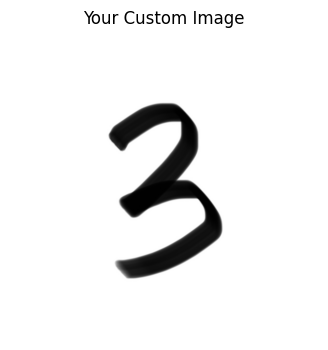

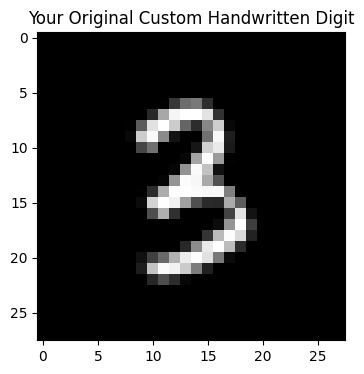

Original MLP Model Prediction for your custom image: 3


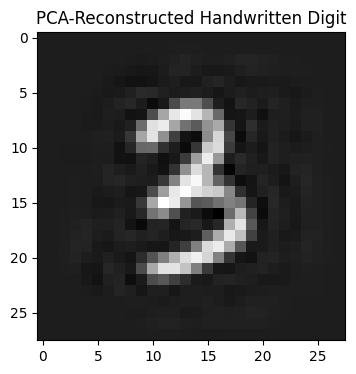

PCA-then-Scaled MLP Model Prediction for your custom image: 3


In [ ]:
# --- Test with Your Own Handwritten Image ---
print("\n--- Testing with a Custom Handwritten Image ---")
custom_img_path = "three_1.JPG" # <--- IMPORTANT: Replace with your actual image path
try:
    # Open the image using Pillow (PIL)
    img = PIL_Image.open(custom_img_path)

    # Convert the image to a NumPy array
    img_arr = np.array(img)

    # Display the image using Matplotlib
    plt.figure(figsize=(4, 4)) # Adjust figure size as needed
    plt.imshow(img_arr)
    plt.title("Your Custom Image")
    plt.axis('off') # Hide axes
    plt.show()

except FileNotFoundError:
    print(f"Error: Image not found at {custom_img_path}")
except Exception as e:
    print(f"An error occurred while trying to display the image: {e}")

# Get raw pixels (0-255) for custom image
raw_custom_img_input = get_raw_user_img_pixels(custom_img_path)

if raw_custom_img_input is not None:
    # Display the raw custom image
    plt.figure(figsize=(4,4))
    plt.imshow(raw_custom_img_input.reshape(28,28), cmap='gray')
    plt.title("Your Original Custom Handwritten Digit")
    plt.show()

    # Predict with Original MLP (expects scaled data)
    # Assumes scaler_for_original_mlp is from your main script
    scaled_custom_img_for_orig_mlp = scaler_for_original_mlp.transform(raw_custom_img_input)
    pred_custom_by_orig_mlp = predict_digit(model_mlp_original, scaled_custom_img_for_orig_mlp)
    if pred_custom_by_orig_mlp is not None:
        print(f"Original MLP Model Prediction for your custom image: {pred_custom_by_orig_mlp}")

    # Predict with PCA-then-Scaled MLP
    # Assumes pca_unscaled and scaler_pca_results are from your main script
    processed_custom_img_for_pca_mlp = prep_for_pca_scaled_model(
        raw_custom_img_input,
        pca_unscaled,
        scaler_pca_results
    )
    predict_pca_input = processed_custom_img_for_pca_mlp.reshape(1,-1)
    pred_custom_by_pca_scaled_mlp = predict_digit(model_mlp_pca_then_scaled, predict_pca_input)
    test_pca_display = pca_unscaled.inverse_transform(processed_custom_img_for_pca_mlp).reshape(28, 28)
    # Display the image using matplotlib
    plt.figure(figsize=(4,4))
    plt.imshow(test_pca_display, cmap='gray')  # 'gray' colormap for grayscale images
    plt.title("PCA-Reconstructed Handwritten Digit")
    plt.show()
    if pred_custom_by_pca_scaled_mlp is not None:
        print(f"PCA-then-Scaled MLP Model Prediction for your custom image: {pred_custom_by_pca_scaled_mlp}")


Applying PCA (n_components=3) to 10000 UNSCALED samples...
3D Variance Explained :  23.085110881627266 %
Generating 3D plot of UNSCALED MNIST data...


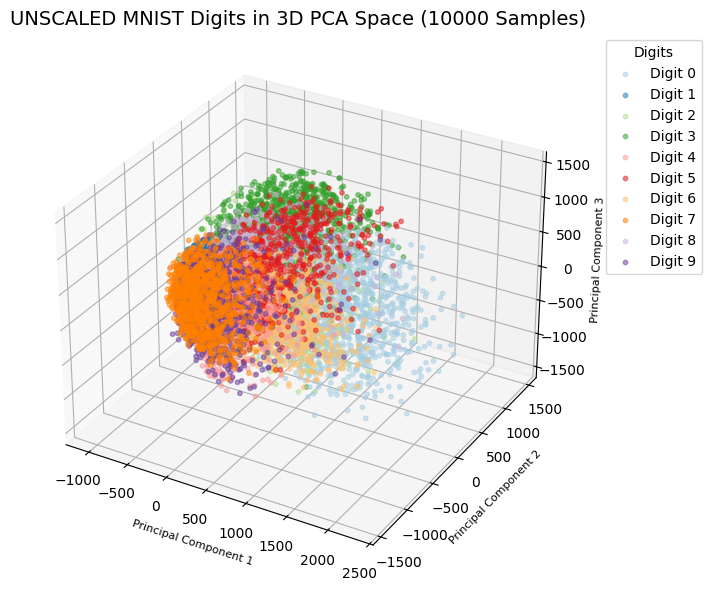


3D PCA plot of UNSCALED data generated.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D # Essential for 3D plots
# --- Configuration for 3D Plotting ---
# Number of samples to plot for 3D visualization.
# Adjust this value to control density. Too many points can be slow/cluttered.
num_samples_to_plot_3d_unscaled = 10000
# Select a subset of the X_train data for plotting
if num_samples_to_plot_3d_unscaled > len(X_train):
    print(f"Warning: num_samples_to_plot_3d_unscaled ({num_samples_to_plot_3d_unscaled}) is greater than available training samples ({len(X_train)}). Using all available samples.")
    X_plot_subset = X_train
    y_plot_subset = y_train
else:
    # Use np.random.choice to get a random subset from X_train
    random_indices = np.random.choice(len(X_train), num_samples_to_plot_3d_unscaled, replace=False)
    X_plot_subset = X_train[random_indices]
    y_plot_subset = y_train[random_indices]


# 2. Apply PCA with n_components = 3 on the UNCALED data
print(f"\nApplying PCA (n_components=3) to {len(X_plot_subset)} UNSCALED samples...")
pca_unscaled_3d = PCA(n_components=3) # New PCA model for this specific plot
X_pca_3d_unscaled_transformed = pca_unscaled_3d.fit_transform(X_plot_subset)
print("3D Variance Explained : ",cumsum[2]*100,"%")
# 3. Plot the 3D PCA-reduced data
print("Generating 3D plot of UNSCALED MNIST data...")

fig = plt.figure(figsize=(8, 6)) # Adjust figure size as needed
ax = fig.add_subplot(111, projection='3d') # Create a single 3D subplot

# Define a colormap for the 10 digits
colors = plt.colormaps['Paired'] # 'tab10' provides distinct colors

# Plot each digit with a different color
for i in range(10):
    # Select points belonging to the current digit class from the subset
    indices = y_plot_subset == i

    # Check if there are any samples for the current digit in the subset
    if np.sum(indices) > 0:
        ax.scatter(X_pca_3d_unscaled_transformed[indices, 0],
                   X_pca_3d_unscaled_transformed[indices, 1],
                   X_pca_3d_unscaled_transformed[indices, 2],
                   color=colors(i),
                   label=f'Digit {i}',
                   alpha=0.5, # Adjust transparency for better visibility
                   s=10)      # Adjust marker size
    else:
        print(f"No samples for digit {i} in the selected subset ({num_samples_to_plot_3d_unscaled} samples).")

ax.set_title(f'UNSCALED MNIST Digits in 3D PCA Space ({len(X_plot_subset)} Samples)', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=8)
ax.set_ylabel('Principal Component 2', fontsize=8)
ax.set_zlabel('Principal Component 3', fontsize=8)
ax.legend(title='Digits', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot

plt.tight_layout()
plt.show()

print("\n3D PCA plot of UNSCALED data generated.")